In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from bio_optics.helper import resampling, utils, owt, indices, plotting

In [9]:
## apply to full EnMAP extracts
## North Sea extracts, EnMAP
datasetName='NorthSeaEnMAPSouth20230815'
df = pd.read_csv(r'Z:\projects\ongoing\EnsAD\workspace\data\Database\\20230815_DB\\20230815_South.csv')
# print(df.columns.values)
a = [str(b) for b in df['OWT'].values]
df['OWT']=np.asarray(a)
# print(np.unique(df['OWT']))
IDvalid = np.array(df['OWT'].values != 'nan')

wavelengths = df.columns[4:84].values.astype(float)
wavelengths = wavelengths[(wavelengths>400) & (wavelengths<750)]
r_rs = df.iloc[:,4:len(wavelengths)+4]
r_rs = r_rs.loc[IDvalid,:]
df = df.loc[IDvalid,:]

# selectionIndex = pd.read_csv(r'E:\Documents\projects\EnsAD\data\EnMAP_NN_training\AANN_NorthSea\trainingDataIndex_InvertibleEnMAPSpectra_NorthSeaEnMAPSouth20230815_selection20240405.txt',
                             # header=0, sep='\t')
selectionIndex = pd.read_csv(r'E:\Documents\projects\EnsAD\data\EnMAP_NN_training\AANN_NorthSea\trainingData_EnMAPSpectra_NorthSeaEnMAPSouth20230815_InvertibleCategory_selection20240405_v2.txt',
                            header=0, sep='\t')
print(selectionIndex.shape, df.shape)

invRrs = pd.read_csv(r'E:\Documents\projects\EnsAD\inversion\HZG_HEREON_groups\results_MK\inverted_Rrs_bio_optics_HEREONfull_NorthSeaEnMAPSouth20230815_V7AHall_md_bd_v2.txt',
                    header=0, sep='\t')
invRrs = invRrs.iloc[300:,:]
print(invRrs.shape)

(1276, 99) (1276, 98)
(1276, 60)


In [61]:
# path = "E:\Documents\projects\EnsAD\\NN_training\AANN_EnMAP\\aann_EnMAP_20240405_v01\I60x31x7x31xO60_\\temp\\"
# path = "E:\Documents\projects\EnsAD\\NN_training\\NN_EnMAP2Model\\nn_EnMAP_20240408_v01\\I60x80x80x80xO60_\\temp\\"
# path = "E:\Documents\projects\EnsAD\\NN_training\\NN_EnMAP2Model\\nn_EnMAP_20240408_v01\I60x80x80x80x80xO60__v2\\temp\\" ## quite good solution!
path = "E:\Documents\projects\EnsAD\\NN_training\\NN_EnMAP2Model\\nn_EnMAP_20240408_v01\I60x100x100x100x100xO60__v2\\temp\\"
fnames = os.listdir(path)
print(fnames)

['I60x100x100x100x100xO60batch20_epoch40000_loss0.04693.h5', 'I60x100x100x100x100xO60_batch20_epoch742_loss0.03151.h5', 'loss_I60x100x100x100x100xO60batch20_epoch40000_loss0.04693.png']


In [67]:
# modelFname = 'I60x80x80x80x80xO60_batch50_epoch20418_loss0.04109.h5'  ## quite good solution!
modelFname = 'I60x100x100x100x100xO60batch20_epoch40000_loss0.04693.h5'
model_ = tf.keras.models.load_model(path + modelFname)
AANN_pred = model_.predict(r_rs)

40/40 [==============================] - 0s 2ms/step


(1276, 60) (1276, 60)


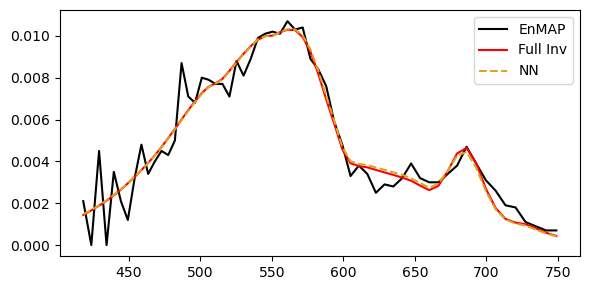

In [69]:
print(AANN_pred.shape, r_rs.shape)
i = 400
fig, ax=plt.subplots(nrows=1, ncols=1, figsize=(6,3))
ax.plot(wavelengths, r_rs.iloc[i,:], 'k-', label='EnMAP')
ax.plot(wavelengths, invRrs.iloc[i,:], '-', color='red', label='Full Inv')
ax.plot(wavelengths, AANN_pred[i,:], '--', color='goldenrod', label='NN')
ax.legend()
fig.tight_layout()
plt.show()

In [70]:
## error
rMAE = np.zeros(r_rs.shape[0])
sam = np.zeros(r_rs.shape[0])

for i in range(len(rMAE)):
    rMAE[i] = np.mean(utils.compute_residual(invRrs.iloc[i].values, AANN_pred[i,:], method=11))
    sam[i] = np.sum(invRrs.iloc[i].values * AANN_pred[i,:])/\
                 (np.sqrt(np.sum(invRrs.iloc[i].values*invRrs.iloc[i].values)) * np.sqrt(np.sum(AANN_pred[i,:]*AANN_pred[i,:])))
    sam[i] = np.arccos(sam[i])
    
sam *=180./np.pi

## error
rMAE_inv = np.zeros(r_rs.shape[0])
rMAE_nn = np.zeros(r_rs.shape[0])
for i in range(len(rMAE_inv)):
    rMAE_inv[i] = np.mean(utils.compute_residual(r_rs.iloc[i].values, invRrs.iloc[i,:], method=11))
    rMAE_nn[i] = np.mean(utils.compute_residual(r_rs.iloc[i].values, AANN_pred[i,:], method=11))

['4a' '4b' '5a' '5b' '6' '7']
0.11006519448575323


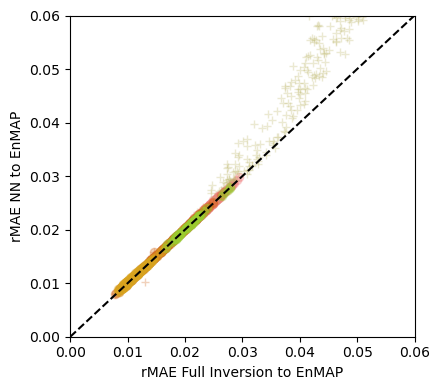

In [73]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
# ax.plot(rMAE_inv, rMAE_nn, '+', alpha=0.3)
# ax.set_xlabel('rMAE Full Inversion to EnMAP')
# ax.set_ylabel('rMAE NN to EnMAP')
# xlim= (0., 0.16)
# ax.plot(xlim, xlim, 'k--')
# fig.tight_layout()
# plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5,4))
colorList = ['lightcoral', 'chocolate', 'goldenrod', 'darkkhaki', 'yellowgreen', 'cadetblue', 'orchid', 'slateblue', 'hotpink']
owtList = np.unique(df['OWT'])
print(owtList)
print(np.max(rMAE))
for i, owt in enumerate(owtList):
    ID = np.array(df['OWT'].values == owt)
    ax.plot(rMAE_inv[ID], rMAE_nn[ID], '+', color=colorList[i], alpha=0.3)
    ID = np.logical_and(np.array(df['OWT'].values == owt), np.array(selectionIndex['invertible'].values==1))
    ax.plot(rMAE_inv[ID], rMAE_nn[ID], 'o', color=colorList[i], alpha=0.3)
    
ax.set_xlabel('rMAE Full Inversion to EnMAP')
ax.set_ylabel('rMAE NN to EnMAP')
xlim= (0., 0.06) # (0., 0.16)
ax.plot(xlim, xlim, 'k--')
ax.set_xlim(xlim)
ax.set_ylim(xlim)
fig.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['4a' '4b' '5a' '5b' '6' '7']
0.11006519448575323


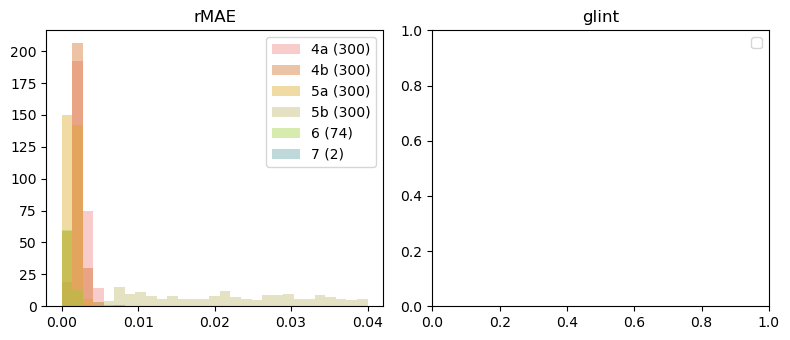

In [74]:
## histogram rMAE and glint strength
Nx = 2
bins = np.linspace(0.00, 0.04, 30) # North Sea: 0.06, Baltic: 0.27, FullDB (not Baltic): 0.2 
colorList = ['lightcoral', 'chocolate', 'goldenrod', 'darkkhaki', 'yellowgreen', 'cadetblue', 'orchid', 'slateblue', 'hotpink']
fig, ax = plt.subplots(nrows=1, ncols=Nx, figsize=(8,3.5))
owtList = np.unique(df['OWT'])
print(owtList)
print(np.max(rMAE))
for i, owt in enumerate(owtList):
    ID = np.array(df['OWT'].values == owt)
    ax[0].hist(rMAE[ID], bins=bins, color=colorList[i], alpha=0.4, label=owt + " ("+ str(int(np.sum(ID)))+")")
    # ax[1].hist(SpectralErrorDict[key]['glint'],  color=RrsResultDict[key]['col'], alpha=0.4, label=key)

ax[0].set_title('rMAE')
ax[1].set_title('glint')
for i in range(Nx):
    ax[i].legend()

fig.tight_layout()
plt.show()

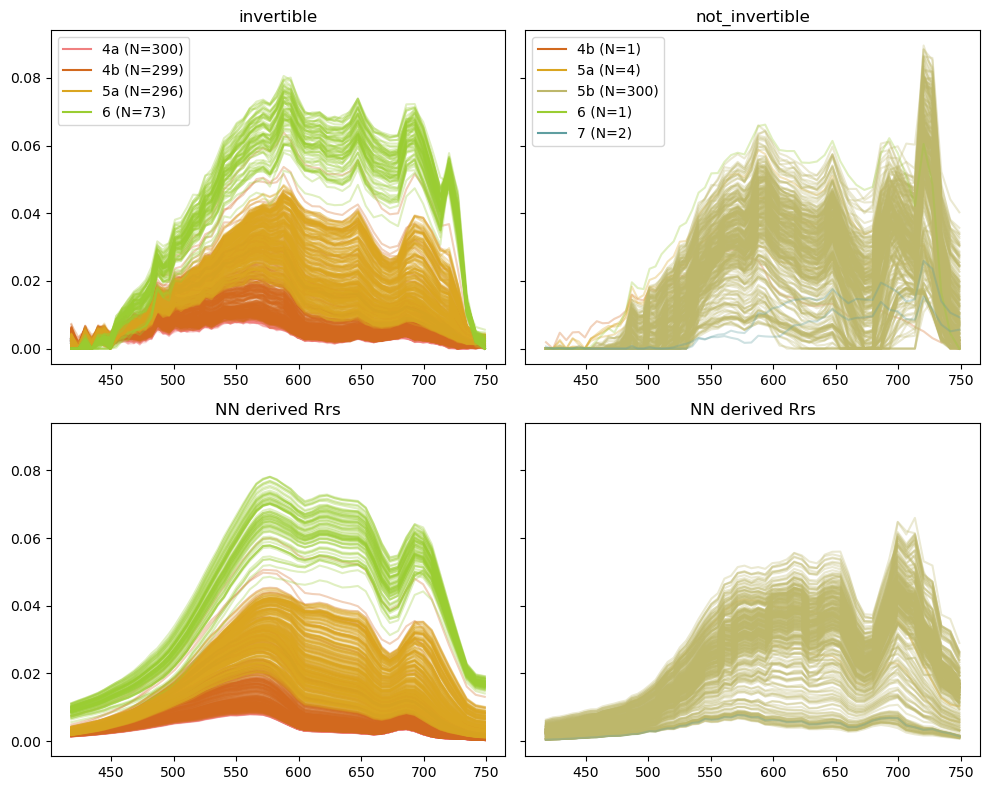

In [48]:
colorList = ['lightcoral', 'chocolate', 'goldenrod', 'darkkhaki', 'yellowgreen', 'cadetblue', 'orchid', 'slateblue', 'hotpink']
allOWTs = np.unique(df['OWT'].values)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,8), sharey=True)
ID = np.array(selectionIndex['invertible'].values==1)
inv_rrs = r_rs.loc[ID,:].values
nn_pred = AANN_pred[ID,:]
inv_owt = df['OWT'].values[ID]
for col, owt in zip(colorList, allOWTs):
    ID2 = np.array(inv_owt == owt)
    if np.sum(ID2)>0:
        for i in range(np.sum(ID2)):
            if i==0:
                ax[0,0].plot(wavelengths, inv_rrs[ID2,:][i, :], '-', color=col, alpha=0.3, label=owt + " (N=" + str(int(np.sum(ID2))) + ')')
            else:
                ax[0,0].plot(wavelengths, inv_rrs[ID2,:][i, :], '-', color=col, alpha=0.3)
                ax[1,0].plot(wavelengths, nn_pred[ID2,:][i, :], '-', color=col, alpha=0.3)
                
ax[0,0].set_title('invertible')
ax[1,0].set_title('NN derived Rrs')
legend = ax[0,0].legend()
handles = legend.legendHandles
for i, handle in enumerate(handles):
    handle.set_alpha(1)

inv_rrs = r_rs.loc[np.logical_not(ID),:].values
nn_pred = AANN_pred[np.logical_not(ID),:]
inv_owt = df['OWT'].values[np.logical_not(ID)]
for col, owt in zip(colorList, allOWTs):
    ID2 = np.array(inv_owt == owt)
    if np.sum(ID2)>0:
        for i in range(np.sum(ID2)):
            if i==0:
                ax[0,1].plot(wavelengths, inv_rrs[ID2,:][i, :], '-', color=col, alpha=0.3, label=owt + " (N=" + str(int(np.sum(ID2))) + ')')
            else:
                ax[0, 1].plot(wavelengths, inv_rrs[ID2,:][i, :], '-', color=col, alpha=0.3)
                ax[1, 1].plot(wavelengths, nn_pred[ID2,:][i, :], '-', color=col, alpha=0.3)

ax[0,1].set_title('not_invertible')
ax[1,1].set_title('NN derived Rrs')
legend = ax[0,1].legend()
handles = legend.legendHandles
for i, handle in enumerate(handles):
    handle.set_alpha(1)
fig.tight_layout()
plt.show()